# Imports and Device Setup

In [1]:
import os
import librosa
import numpy as np
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import AdamW
from torch.optim.lr_scheduler import ReduceLROnPlateau
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns
import matplotlib.pyplot as plt
import noisereduce as nr
import soundfile as sf
from collections import Counter
import pandas as pd
# Device setup
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


# Exact Dataset Path

In [2]:
dataset_path = r"C:\Users\Jim\Jupiter Projects\CSE499\B-SER dataset"
mendeley_dataset_path = r"C:\Users\Jim\Jupiter Projects\CSE499\KUET Bangla Emotional Speech (KBES) Dataset"
fear_dataset_path = r"C:\Users\Jim\Jupiter Projects\CSE499\North South Bangla Emotional Speech\Fear"
reduced_audio_path = r"D:\Study\2025 Fall\CSE499\Project Dataset\Noise Reduced Data"
augmented_audio_path = r"D:\Study\2025 Fall\CSE499\Project Dataset\Augmented Data"

# Data Preprocessing Functions

In [3]:
def standardize_audio(file_path, target_length=3, sample_rate=16000):
    try:
        waveform, sr = librosa.load(file_path, sr=sample_rate)
        target_samples = int(target_length * sample_rate)
        if len(waveform) < target_samples:
            waveform = np.pad(waveform, (0, target_samples - len(waveform)), mode='constant')
        else:
            waveform = waveform[:target_samples]
        return waveform, sr
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        raise

def augment_to_target(paths, labels, target_count=506, augmented_base_path=augmented_audio_path):
    print("Starting augmentation...")
    label_counts = Counter(labels)
    all_paths, all_labels = paths.copy(), labels.copy()
    
    for label in label_counts:
        original_count = label_counts[label]
        print(f"Label {label}: {original_count} original samples")
        label_dir = os.path.join(augmented_base_path, label)
        os.makedirs(label_dir, exist_ok=True)
        
        existing_files = [f for f in os.listdir(label_dir) if f.endswith(".wav")]
        total_current = original_count + len(existing_files)
        
        if total_current >= target_count:
            print(f"  Reusing existing files for {label}: {total_current} samples already exist")
            for f in existing_files:
                file_path = os.path.join(label_dir, f)
                if file_path not in all_paths:
                    all_paths.append(file_path)
                    all_labels.append(label)
            continue
        
        for f in existing_files:
            os.remove(os.path.join(label_dir, f))
        print(f"  Cleared {len(existing_files)} existing files in {label_dir} (needed {target_count}, had {total_current})")
        
        label_paths = [p for p, l in zip(paths, labels) if l == label]
        needed = target_count - original_count
        aug_types = ["pitch_1", "pitch_2", "pitch_neg_1", "pitch_neg_2", "stretch_1.05", "stretch_1.1", "noise_0.005"]
        aug_idx = 0
        
        while needed > 0 and aug_idx < target_count * 2:
            orig_idx = aug_idx // len(aug_types) % len(label_paths)
            aug_type = aug_types[aug_idx % len(aug_types)]
            waveform, sr = standardize_audio(label_paths[orig_idx])
            base_name = os.path.basename(label_paths[orig_idx]).replace(".wav", "")
            
            if aug_type.startswith("pitch"):
                n_steps = float(aug_type.split("_")[1]) if "neg" not in aug_type else -float(aug_type.split("_")[2])
                augmented = librosa.effects.pitch_shift(y=waveform, sr=sr, n_steps=n_steps)
                file_name = f"{base_name}_pitch_{n_steps}_{aug_idx}.wav"
            elif aug_type.startswith("stretch"):
                rate = float(aug_type.split("_")[1])
                augmented = librosa.effects.time_stretch(y=waveform, rate=rate)
                file_name = f"{base_name}_stretch_{rate}_{aug_idx}.wav"
            elif aug_type.startswith("noise"):
                noise_level = float(aug_type.split("_")[1])
                noise = np.random.normal(0, noise_level, waveform.shape)
                augmented = waveform + noise
                file_name = f"{base_name}_noise_{noise_level}_{aug_idx}.wav"
            
            aug_path = os.path.join(label_dir, file_name)
            sf.write(aug_path, augmented, sr)
            if aug_path not in all_paths:
                all_paths.append(aug_path)
                all_labels.append(label)
            needed -= 1
            aug_idx += 1
        
        print(f"  Augmented {label} to {len([l for l in all_labels if l == label])} samples")
    
    total_samples = len(all_paths)
    print(f"Total augmented samples: {total_samples}")
    if total_samples < 7 * target_count:
        print(f"Warning: Only {total_samples} samples generated, expected {7 * target_count}")
    return all_paths, all_labels

def reduce_noise(waveform, sr, output_path, label):
    if label in ["fear", "disgust"]:
        reduced = nr.reduce_noise(y=waveform, sr=sr, prop_decrease=0.3)
    else:
        reduced = nr.reduce_noise(y=waveform, sr=sr, prop_decrease=0.7)
    sf.write(output_path, reduced, sr)
    if not os.path.exists(output_path):
        raise Exception(f"Failed to write {output_path}")
    return output_path

# Dataset Loading Functions

In [4]:
def load_bser_dataset(dataset_path, target_length=3):
    paths, labels = [], []
    label_mapping = {"01": "happy", "02": "sad", "03": "angry", "04": "surprise", "05": "neutral"}
    for actor in range(1, 35):
        actor_path = os.path.join(dataset_path, f"Actor {actor:02d}")
        if not os.path.isdir(actor_path):
            print(f"Skipping {actor_path}: not a directory")
            continue
        for file in os.listdir(actor_path):
            if file.endswith(".wav"):
                parts = file.split("-")
                if len(parts) < 3 or parts[2] not in label_mapping:
                    continue
                file_path = os.path.join(actor_path, file)
                paths.append(file_path)
                labels.append(label_mapping[parts[2]])
    print(f"B-SER: {len(paths)} files loaded")
    return paths, labels

def load_kbes_dataset(dataset_path, target_length=3):
    paths, labels = [], []
    label_mapping = {
        "Angry (High)": "angry", "Angry (Low)": "angry",
        "Happy (High)": "happy", "Happy (Low)": "happy",
        "Neutral": "neutral",
        "Sad (High)": "sad", "Sad (Low)": "sad",
        "Disgust": "disgust", "Disgust (High)": "disgust", "Disgust (Low)": "disgust"
    }
    for emotion_folder in os.listdir(dataset_path):
        emotion_path = os.path.join(dataset_path, emotion_folder)
        if not os.path.isdir(emotion_path):
            continue
        if emotion_folder not in label_mapping:
            print(f"Skipping unknown folder: {emotion_folder}")
            continue
        num_files = len([f for f in os.listdir(emotion_path) if f.endswith(".wav")])
        print(f"{emotion_folder}: {num_files} files")
        for file in os.listdir(emotion_path):
            if file.endswith(".wav"):
                file_path = os.path.join(emotion_path, file)
                paths.append(file_path)
                labels.append(label_mapping[emotion_folder])
    print(f"KBES: {len(paths)} files loaded")
    return paths, labels

def load_fear_dataset(dataset_path, target_length=3):
    paths, labels = [], []
    for file in os.listdir(dataset_path):
        if file.endswith(".wav"):
            file_path = os.path.join(dataset_path, file)
            paths.append(file_path)
            labels.append("fear")
    print(f"Fear: {len(paths)} files loaded")
    return paths, labels

def process_and_reduce_noise(paths, labels, reduced_base_path):
    reduced_paths, reduced_labels = [], []
    for path, label in zip(paths, labels):
        if not os.path.exists(path):
            print(f"Warning: {path} does not exist, skipping")
            continue
        label_dir = os.path.join(reduced_base_path, label)
        os.makedirs(label_dir, exist_ok=True)
        base_name = os.path.basename(path).replace(".wav", "_reduced.wav")
        reduced_file = os.path.join(label_dir, base_name)
        if not os.path.exists(reduced_file):
            waveform, sr = standardize_audio(path)
            reduce_noise(waveform, sr, reduced_file, label)
        reduced_paths.append(reduced_file)
        reduced_labels.append(label)
    print(f"Total reduced samples: {len(reduced_paths)}")
    return reduced_paths, reduced_labels

# Feature Extraction and Dataset Class

In [5]:
def extract_combined_features(file_path, sample_rate=16000, n_mfcc=40, n_mels=40, n_frames=300):
    waveform, sr = librosa.load(file_path, sr=sample_rate)
    
    # MFCC
    mfcc = librosa.feature.mfcc(y=waveform, sr=sr, n_mfcc=n_mfcc, hop_length=len(waveform)//(n_frames-1))
    if mfcc.shape[1] < n_frames:
        mfcc = np.pad(mfcc, ((0, 0), (0, n_frames - mfcc.shape[1])), mode='constant') # padding shorter sequences with zeros
    else:
        mfcc = mfcc[:, :n_frames] # Truncates excess frames
        
    # MEL FREQ
    mel_spec = librosa.feature.melspectrogram(y=waveform, sr=sr, n_mels=n_mels, hop_length=len(waveform)//(n_frames-1))
    log_mel = librosa.power_to_db(mel_spec, ref=np.max) #converts a Mel spectrogram from power to decibel (dB) units using a logarithmic scale
    if log_mel.shape[1] < n_frames:
        log_mel = np.pad(log_mel, ((0, 0), (0, n_frames - log_mel.shape[1])), mode='constant') #padding shorter sequences with zeros
    else:
        log_mel = log_mel[:, :n_frames] # Truncates excess frames
    return np.concatenate((mfcc, log_mel), axis=0)  # Shape: (80, 300)

def compute_features_in_memory(paths):
    features = []
    for file_path in paths:
        feat = extract_combined_features(file_path)
        features.append(feat)
    return features

class AudioDataset(Dataset):
    def __init__(self, features, labels, label_map):
        self.features = features
        self.labels = [label_map[l] for l in labels]

    def __len__(self):
        return len(self.features)

    def __getitem__(self, idx):
        return torch.tensor(self.features[idx], dtype=torch.float32), torch.tensor(self.labels[idx], dtype=torch.long)

# Model Definition

In [6]:
class CNNBackbones(nn.Module):
    def __init__(self):
        super(CNNBackbones, self).__init__()
        self.block1 = nn.Sequential(
            nn.Conv1d(80, 64, kernel_size=3, padding=1),
            nn.BatchNorm1d(64),
            nn.ReLU(),
            nn.Dropout(0.3)
        )
        self.pool1 = nn.MaxPool1d(2)
        self.block2 = nn.Sequential(
            nn.Conv1d(64, 128, kernel_size=3, padding=1),
            nn.BatchNorm1d(128),
            nn.ReLU(),
            nn.Dropout(0.1)
        )
        self.pool2 = nn.AdaptiveMaxPool1d(31)

    def forward(self, x):
        x = self.block1(x)
        x = self.pool1(x)
        x = self.block2(x)
        x = self.pool2(x)
        return x

class CNNTransformerHybrid(nn.Module):
    def __init__(self, num_classes=7):
        super(CNNTransformerHybrid, self).__init__()
        self.cnn = CNNBackbones()
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=128, nhead=4, dim_feedforward=512, dropout=0.1, batch_first=True
        )
        self.transformer = nn.TransformerEncoder(encoder_layer, num_layers=2)
        self.fc = nn.Sequential(
            nn.Linear(31 * 256, 512),
            nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(512, num_classes)
        )

    def forward(self, x):
        cnn_out = self.cnn(x)
        transformer_in = cnn_out.permute(0, 2, 1) # Switches dimensions to [batch, time, features] format expected by Transformer
        transformer_out = self.transformer(transformer_in)
        combined = torch.cat((cnn_out.permute(0, 2, 1), transformer_out), dim=-1)
        combined = combined.reshape(combined.size(0), -1)
        out = self.fc(combined)
        return out

# Training and Evaluation Functions

In [ ]:
# [batch, features, time]
# Input: (64, 80, 300)
# CNN Block 1 Conv: (64, 64, 300)
# CNN Block 1 Pool: (64, 64, 150)
# CNN Block 2 Conv: (64, 128, 150)
# CNN Block 2 Pool: (64, 128, 31)
# [batch, time, features]
# Transformer Input: (64, 31, 128)
# Transformer Output: (64, 31, 128)
# Fusion Concat: (64, 31, 256)
# Fusion Flatten: (64, 7936)
# FC Linear 1: (64, 512)
# FC Linear 2: (64, 7)

In [7]:
def train_model(model, train_loader, val_loader, num_epochs=500, patience=20):
    model = model.to(device)
    optimizer = AdamW(model.parameters(), lr=5e-4, weight_decay=1e-4)  
    scheduler = ReduceLROnPlateau(optimizer, mode='max', factor=0.5, patience=15, min_lr=1e-6)
    class_weights = torch.tensor([1.0, 1.0, 1.0, 1.0, 1.0, 3.0, 3.0], dtype=torch.float32).to(device)  # Initilize weight, giving disgust and fear more.
    criterion = nn.CrossEntropyLoss(weight=class_weights, label_smoothing=0.1).to(device)
    
    best_val_accuracy = -float('inf')
    best_model_state = None
    patience_counter = 0
    save_path = "CSE499_Model.pth"  # File path for saving the best model
    
    # Lists to store metrics for plotting
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []
    best_epoch = 0  # To track the epoch with the best validation accuracy
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        all_train_preds, all_train_labels = [], []
        for i, (inputs, targets) in enumerate(train_loader):
            inputs, targets = inputs.to(device), targets.to(device)  # Moving data to GPU
            optimizer.zero_grad()  # Resetting gradient every epoch
            outputs = model(inputs) 
            loss = criterion(outputs, targets)
            
            # Backward and optimize
            loss.backward()
            optimizer.step()
            running_loss += loss.item()
            
            # Collect predictions for training accuracy
            _, preds = torch.max(outputs, 1)
            all_train_preds.extend(preds.cpu().numpy())
            all_train_labels.extend(targets.cpu().numpy())
        
        avg_train_loss = running_loss / len(train_loader)
        train_accuracy = accuracy_score(all_train_labels, all_train_preds)
        train_losses.append(avg_train_loss)
        train_accuracies.append(train_accuracy)
        
        # Validation phase
        model.eval()
        running_val_loss = 0.0
        all_val_preds, all_val_labels = [], []
        with torch.no_grad():
            for inputs, targets in val_loader:
                inputs, targets = inputs.to(device), targets.to(device)
                outputs = model(inputs)
                loss = criterion(outputs, targets)
                running_val_loss += loss.item()
                
                _, preds = torch.max(outputs, 1)
                all_val_preds.extend(preds.cpu().numpy())
                all_val_labels.extend(targets.cpu().numpy())
        
        avg_val_loss = running_val_loss / len(val_loader)
        val_accuracy = accuracy_score(all_val_labels, all_val_preds)
        val_losses.append(avg_val_loss)
        val_accuracies.append(val_accuracy)
        
        print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {avg_train_loss:.4f}, Val Loss: {avg_val_loss:.4f}, "
              f"Train Accuracy: {train_accuracy:.4f}, Val Accuracy: {val_accuracy:.4f}, LR: {optimizer.param_groups[0]['lr']:.6f}")
        
        scheduler.step(val_accuracy)
        
        if val_accuracy > best_val_accuracy:
            best_val_accuracy = val_accuracy
            best_model_state = model.state_dict()
            torch.save(best_model_state, save_path)  # Save the best model state
            patience_counter = 0
            best_epoch = epoch  # Update best epoch
            print(f"  New best model saved to {save_path} with Val Accuracy: {best_val_accuracy:.4f}")
        else:
            patience_counter += 1
            print(f"  No improvement. Patience counter: {patience_counter}/{patience}")
        
        if patience_counter >= patience:
            print(f"Early stopping triggered after {epoch+1} epochs.")
            model.load_state_dict(best_model_state)
            break
    
    # --- Plotting ---
    plt.figure(figsize=(15, 6))
    
    # Accuracy plot (Left)
    plt.subplot(1, 2, 1)
    plt.plot(train_accuracies, label='Train Accuracy', color='blue', alpha=0.7)
    plt.plot(val_accuracies, label='Validation Accuracy', color='green', alpha=0.7)
    plt.axvline(x=best_epoch, color='r', linestyle='--', 
                label=f'Best Epoch: {best_epoch+1}')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.title('Training vs Validation Accuracy')
    plt.legend()
    
    # Loss plot (Right)
    plt.subplot(1, 2, 2)
    plt.plot(train_losses, label='Train Loss', color='blue', alpha=0.7)
    plt.plot(val_losses, label='Validation Loss', color='green', alpha=0.7)
    plt.axvline(x=best_epoch, color='r', linestyle='--')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.title('Training vs Validation Loss')
    plt.legend()
    
    plt.tight_layout()
    plt.show()
    
    print(f"Training complete. Best Val Accuracy: {best_val_accuracy:.4f} at epoch {best_epoch+1}")
    
    return model

In [8]:
def evaluate_model(model, test_loader, label_map):
    model = model.to(device)
    model.eval()
    all_preds, all_labels = [], []
    with torch.no_grad():
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(targets.cpu().numpy())

    unique_labels = np.unique(all_labels)
    label_map_inv = {v: k for k, v in label_map.items()}
    present_classes = [label_map_inv[i] for i in unique_labels]

    print("Classes present in test set:", present_classes)
    print(classification_report(
        all_labels, 
        all_preds, 
        labels=unique_labels, 
        target_names=present_classes, 
        zero_division=0
    ))

    cm = confusion_matrix(all_labels, all_preds, labels=unique_labels)
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=present_classes, yticklabels=present_classes, cmap='Blues')
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()

    class_counts = np.bincount(all_labels, minlength=len(label_map))
    class_acc = [cm[i, i] / class_counts[unique_labels[i]] for i in range(len(unique_labels)) if class_counts[unique_labels[i]] > 0]
    weighted_acc = np.sum(class_acc * class_counts[unique_labels] / len(all_labels))
    print(f"Weighted Accuracy: {weighted_acc:.4f}")
    return weighted_acc  # Return weighted accuracy for multiple runs

# Visualization of Class Distribution

In [9]:
def plot_class_distribution(original_labels, augmented_labels, label_map, title_suffix=""):
    """
    Plots a side-by-side comparison of class distribution before and after augmentation
    
    Parameters:
        original_labels (list): Labels before augmentation
        augmented_labels (list): Labels after augmentation
        label_map (dict): Mapping of emotion names to indices
        title_suffix (str): Optional string to append to title
    """
    plt.figure(figsize=(12, 6))
    
    # Get counts
    original_counts = Counter(original_labels)
    augmented_counts = Counter(augmented_labels)
    
    # Prepare data
    emotions = list(label_map.keys())
    original_values = [original_counts.get(emotion, 0) for emotion in emotions]
    augmented_values = [augmented_counts.get(emotion, 0) for emotion in emotions]
    
    # Create dataframe
    df = pd.DataFrame({
        'Emotion': emotions * 2,
        'Count': original_values + augmented_values,
        'Dataset': ['Original'] * len(emotions) + ['Augmented'] * len(emotions)
    })
    
    # Plot
    ax = sns.barplot(x='Emotion', y='Count', hue='Dataset', data=df, 
                    palette=['#1f77b4', '#ff7f0e'])
    plt.title(f'Class Distribution Before and After Augmentation {title_suffix}', fontsize=14)
    plt.xlabel('Emotion', fontsize=12)
    plt.ylabel('Number of Samples', fontsize=12)
    
    # Add value labels
    for p in ax.patches:
        ax.annotate(f'{int(p.get_height())}', 
                   (p.get_x() + p.get_width() / 2., p.get_height()), 
                   ha='center', va='center', 
                   xytext=(0, 5), 
                   textcoords='offset points')
    
    plt.legend(title='Dataset')
    plt.tight_layout()
    plt.show()

In [10]:
def plot_sample_features(dataset, label_map_inv, sample_idx=None):
    """
    Plots MFCC and Mel spectrogram for a sample with emotion label
    
    Args:
        dataset: Your AudioDataset instance
        label_map_inv: Inverse label mapping {0:'happy', 1:'sad', ...}
        sample_idx: Optional specific index. If None, picks randomly.
    """
    # Get sample
    if sample_idx is None:
        sample_idx = np.random.randint(len(dataset))
    features, label_idx = dataset[sample_idx]
    features = features.numpy()
    
    # Get emotion label
    emotion = label_map_inv[label_idx.item()]
    
    # Split features
    mfcc = features[:40]
    log_mel = features[40:]
    
    # Create plot
    plt.figure(figsize=(16, 6))
    
    # MFCC plot
    plt.subplot(1, 2, 1)
    librosa.display.specshow(mfcc,
                           x_axis='time',
                           sr=16000,
                           hop_length=160,
                           cmap='coolwarm')
    plt.colorbar(format='%+2.1f dB')
    plt.title(f'MFCCs - Emotion: {emotion}\n(Sample {sample_idx})')
    
    # Mel plot
    plt.subplot(1, 2, 2)
    librosa.display.specshow(log_mel,
                           x_axis='time',
                           y_axis='mel',
                           sr=16000,
                           hop_length=160,
                           fmax=8000,
                           cmap='magma')
    plt.colorbar(format='%+2.0f dB')
    plt.title('Log-Mel Spectrogram')
    
    plt.tight_layout()
    plt.show()

# Main Execution

### Load Dataset and Augment

In [11]:
# Load datasets
bser_paths, bser_labels = load_bser_dataset(dataset_path)
kbes_paths, kbes_labels = load_kbes_dataset(mendeley_dataset_path)
fear_paths, fear_labels = load_fear_dataset(fear_dataset_path)

# Combine original paths and labels
all_paths = bser_paths + kbes_paths + fear_paths
all_labels = bser_labels + kbes_labels + fear_labels
print(f"Original samples: {len(all_paths)}")

# Augment to 506 samples per class, reusing existing files
augmented_paths, augmented_labels = augment_to_target(all_paths, all_labels, target_count=506)
# Define label map with 7 classes
label_map = {"neutral": 0, "happy": 1, "sad": 2, "angry": 3, "surprise": 4, "disgust": 5, "fear": 6}
label_map_inv = {v: k for k, v in label_map.items()}  

B-SER: 1467 files loaded
Angry (High): 100 files
Angry (Low): 100 files
Disgust (High): 100 files
Disgust (Low): 100 files
Happy (High): 100 files
Happy (Low): 100 files
Neutral: 100 files
Sad (High): 100 files
Sad (Low): 100 files
KBES: 900 files loaded
Fear: 121 files loaded
Original samples: 2488
Starting augmentation...
Label happy: 506 original samples
  Reusing existing files for happy: 506 samples already exist
Label sad: 506 original samples
  Reusing existing files for sad: 506 samples already exist
Label angry: 506 original samples
  Reusing existing files for angry: 506 samples already exist
Label surprise: 306 original samples
  Reusing existing files for surprise: 506 samples already exist
Label neutral: 343 original samples
  Reusing existing files for neutral: 506 samples already exist
Label disgust: 200 original samples
  Reusing existing files for disgust: 506 samples already exist
Label fear: 121 original samples
  Reusing existing files for fear: 506 samples already 

### Reduce Noise and Load to RAM

In [12]:
# Reduce noise for all audios
reduced_paths, reduced_labels = process_and_reduce_noise(augmented_paths, augmented_labels, reduced_audio_path)

# Compute features in memory
print("Computing features in memory...")
all_features = compute_features_in_memory(reduced_paths)
dataset = AudioDataset(all_features, reduced_labels, label_map)
print(f"Total samples: {len(dataset)}")

Total reduced samples: 3542
Computing features in memory...
Total samples: 3542


### Visualize

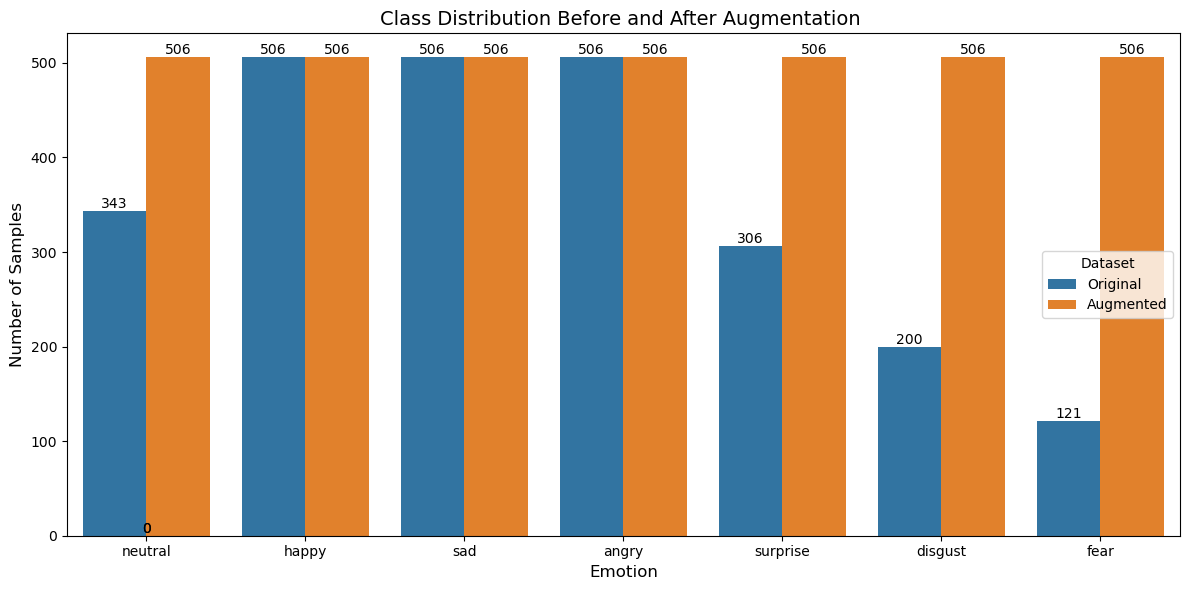

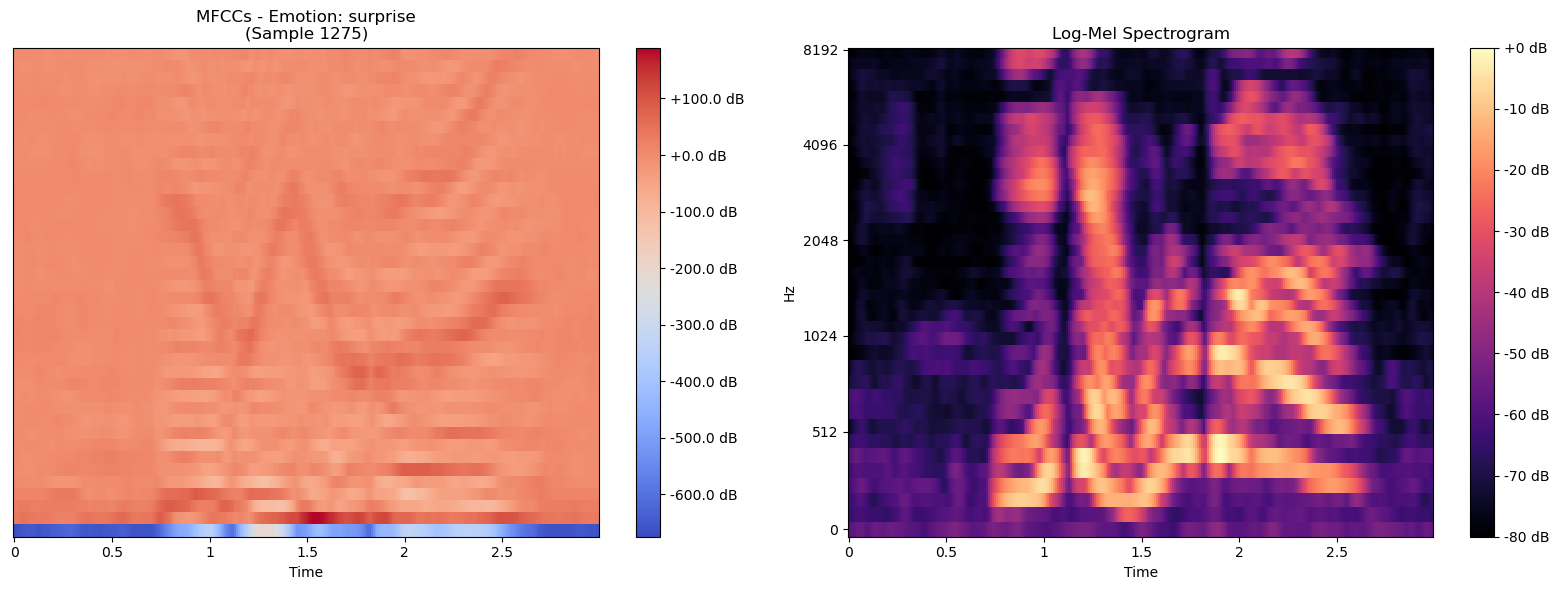

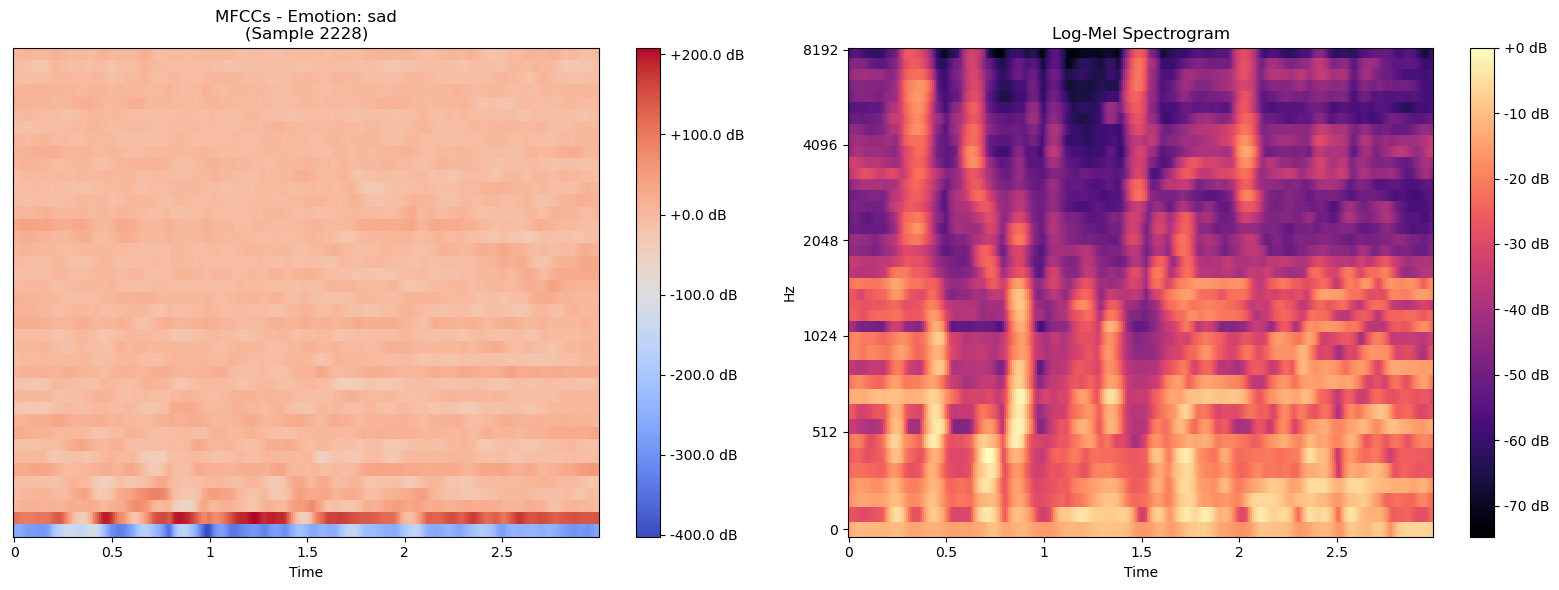

In [13]:
#-----------------------------------------------------
# Visualize class distribution before and after augmentation
plot_class_distribution(all_labels, augmented_labels, label_map)
#------------------------------------------

# Visualize a random sample
plot_sample_features(dataset, label_map_inv)

# Visualize specific sample
plot_sample_features(dataset, label_map_inv)

### Split and Prepare Data Loaders

In [14]:
# Stratified split
numerical_labels = [label_map[label] for label in reduced_labels]
print(f"Label distribution: {np.bincount(numerical_labels)}")

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.2, random_state=42)
train_val_idx, test_idx = next(sss.split(np.zeros(len(dataset)), numerical_labels))  
train_val_labels = [numerical_labels[i] for i in train_val_idx]

sss = StratifiedShuffleSplit(n_splits=1, test_size=0.125, random_state=42)
train_idx, val_idx = next(sss.split(np.zeros(len(train_val_idx)), train_val_labels))

train_dataset = torch.utils.data.Subset(dataset, train_idx) # 70% Train
val_dataset = torch.utils.data.Subset(dataset, val_idx) # 10% Validation
test_dataset = torch.utils.data.Subset(dataset, test_idx) # 20% Testing

print(f"Train samples: {len(train_dataset)}, Val samples: {len(val_dataset)}, Test samples: {len(test_dataset)}")
test_labels = [dataset[i][1].item() for i in test_idx]
print(f"Test set label distribution: {np.bincount(test_labels)}")

train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True, num_workers=0, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=64, num_workers=0, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=64, num_workers=0, pin_memory=True)
print(f"Train batches: {len(train_loader)}")

Label distribution: [506 506 506 506 506 506 506]
Train samples: 2478, Val samples: 355, Test samples: 709
Test set label distribution: [101 101 101 102 101 101 102]
Train batches: 39


# Model Training and Evaluation

Total parameters: 4504391
Starting training (single run)...
Epoch 1/500, Train Loss: 1.6752, Val Loss: 1.5488, Train Accuracy: 0.4165, Val Accuracy: 0.3972, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.3972
Epoch 2/500, Train Loss: 1.3098, Val Loss: 1.2610, Train Accuracy: 0.5682, Val Accuracy: 0.6141, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.6141
Epoch 3/500, Train Loss: 1.1757, Val Loss: 1.2367, Train Accuracy: 0.6622, Val Accuracy: 0.6028, LR: 0.000500
  No improvement. Patience counter: 1/20
Epoch 4/500, Train Loss: 1.0727, Val Loss: 1.2496, Train Accuracy: 0.7248, Val Accuracy: 0.5944, LR: 0.000500
  No improvement. Patience counter: 2/20
Epoch 5/500, Train Loss: 1.0173, Val Loss: 1.2088, Train Accuracy: 0.7647, Val Accuracy: 0.6423, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.6423
Epoch 6/500, Train Loss: 0.9166, Val Loss: 1.2085, Train Accuracy: 0.8180, Val Accuracy: 0.6479, LR: 

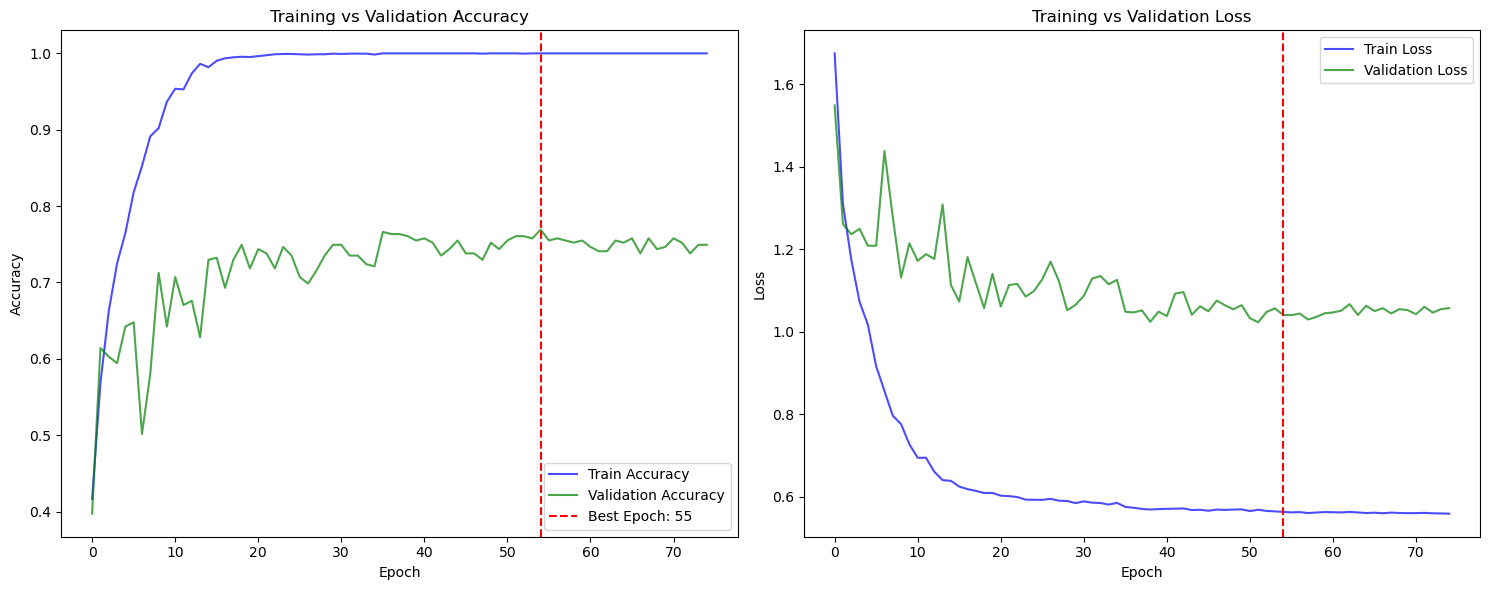

Training complete. Best Val Accuracy: 0.7690 at epoch 55
Classes present in test set: ['neutral', 'happy', 'sad', 'angry', 'surprise', 'disgust', 'fear']
              precision    recall  f1-score   support

     neutral       0.92      0.96      0.94       101
       happy       0.97      0.93      0.95       101
         sad       0.95      0.96      0.96       101
       angry       0.98      0.92      0.95       102
    surprise       0.98      0.99      0.99       101
     disgust       0.91      0.95      0.93       101
        fear       0.97      0.97      0.97       102

    accuracy                           0.95       709
   macro avg       0.96      0.95      0.95       709
weighted avg       0.96      0.95      0.95       709



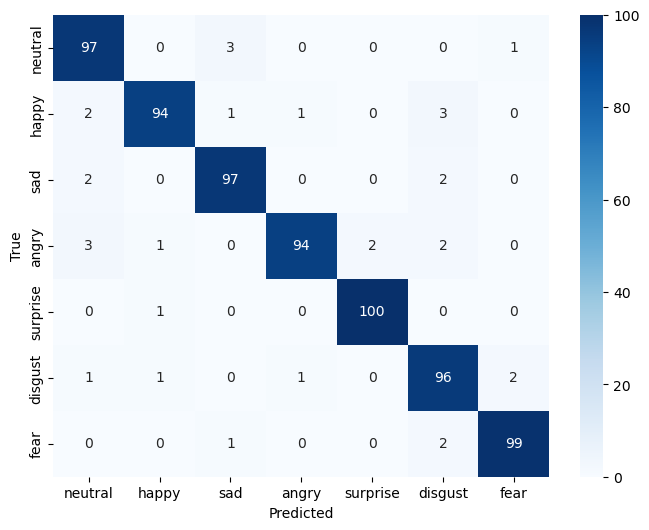

Weighted Accuracy: 0.9549


In [15]:
# Single run (original execution)
torch.cuda.empty_cache()
model = CNNTransformerHybrid(num_classes=7).to(device)
total_params = sum(p.numel() for p in model.parameters())
print(f"Total parameters: {total_params}")
print("Starting training (single run)...")
model = train_model(model, train_loader, val_loader, num_epochs=500, patience=20)
weighted_acc_single = evaluate_model(model, test_loader, label_map)




Starting 10-run evaluation...

Run 1/10
Epoch 1/500, Train Loss: 1.6762, Val Loss: 1.4867, Train Accuracy: 0.4084, Val Accuracy: 0.4338, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.4338
Epoch 2/500, Train Loss: 1.2909, Val Loss: 1.3663, Train Accuracy: 0.5936, Val Accuracy: 0.5690, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.5690
Epoch 3/500, Train Loss: 1.1631, Val Loss: 1.2913, Train Accuracy: 0.6679, Val Accuracy: 0.6028, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.6028
Epoch 4/500, Train Loss: 1.0705, Val Loss: 1.2819, Train Accuracy: 0.7280, Val Accuracy: 0.5831, LR: 0.000500
  No improvement. Patience counter: 1/20
Epoch 5/500, Train Loss: 0.9706, Val Loss: 1.2371, Train Accuracy: 0.7902, Val Accuracy: 0.6338, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.6338
Epoch 6/500, Train Loss: 0.8927, Val Loss: 1.1866, Train Accuracy: 0.8333, Val Accuracy: 0.6

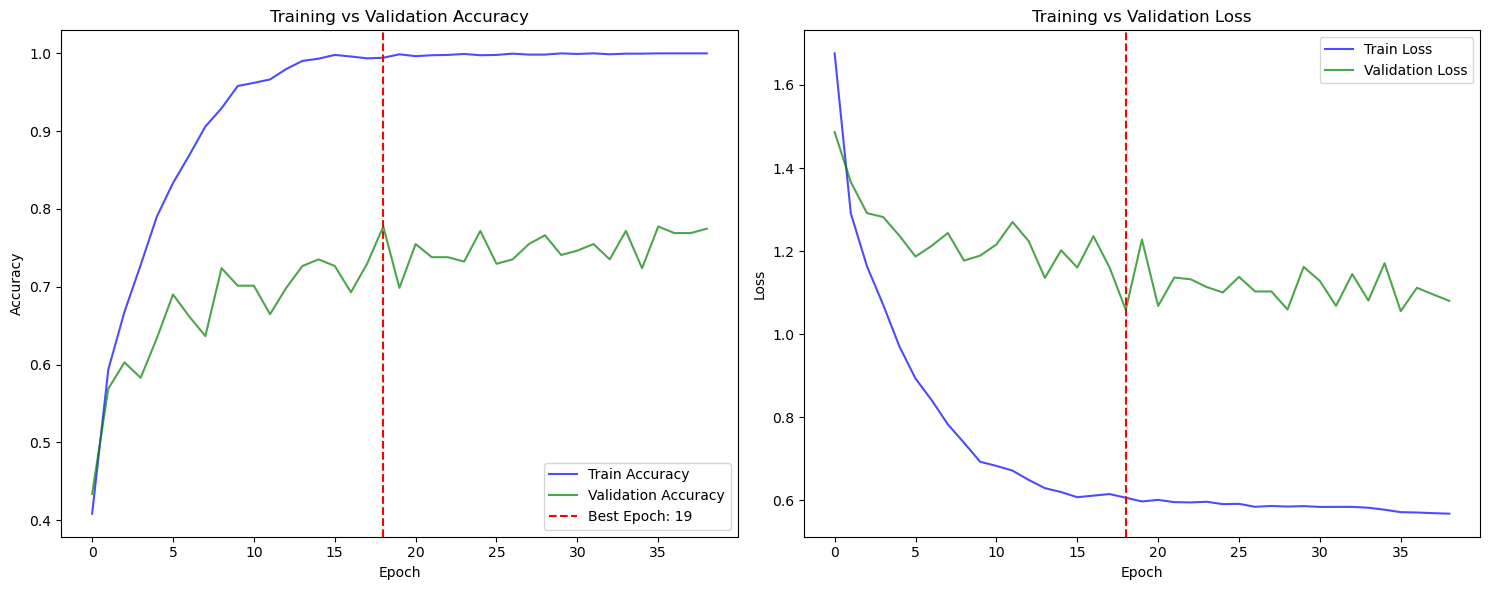

Training complete. Best Val Accuracy: 0.7775 at epoch 19
Classes present in test set: ['neutral', 'happy', 'sad', 'angry', 'surprise', 'disgust', 'fear']
              precision    recall  f1-score   support

     neutral       0.97      0.96      0.97       101
       happy       0.97      0.93      0.95       101
         sad       0.95      1.00      0.98       101
       angry       0.99      0.97      0.98       102
    surprise       0.99      0.99      0.99       101
     disgust       0.92      0.96      0.94       101
        fear       0.96      0.94      0.95       102

    accuracy                           0.96       709
   macro avg       0.97      0.96      0.96       709
weighted avg       0.97      0.96      0.96       709



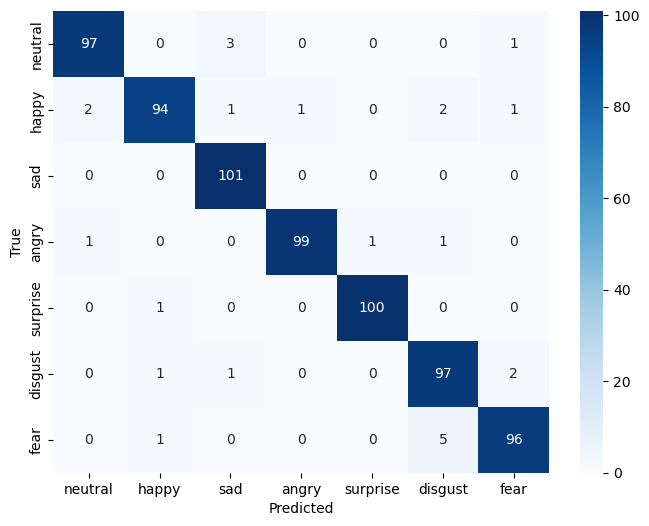

Weighted Accuracy: 0.9647

Run 2/10
Epoch 1/500, Train Loss: 1.8012, Val Loss: 1.4311, Train Accuracy: 0.3773, Val Accuracy: 0.4563, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.4563
Epoch 2/500, Train Loss: 1.2936, Val Loss: 1.3932, Train Accuracy: 0.5827, Val Accuracy: 0.4620, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.4620
Epoch 3/500, Train Loss: 1.1853, Val Loss: 1.2139, Train Accuracy: 0.6477, Val Accuracy: 0.6085, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.6085
Epoch 4/500, Train Loss: 1.0562, Val Loss: 1.2041, Train Accuracy: 0.7320, Val Accuracy: 0.6254, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.6254
Epoch 5/500, Train Loss: 0.9888, Val Loss: 1.1872, Train Accuracy: 0.7700, Val Accuracy: 0.6704, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.6704
Epoch 6/500, Train Loss: 0.9150, Val Loss: 1.1554, Train Accuracy: 0.

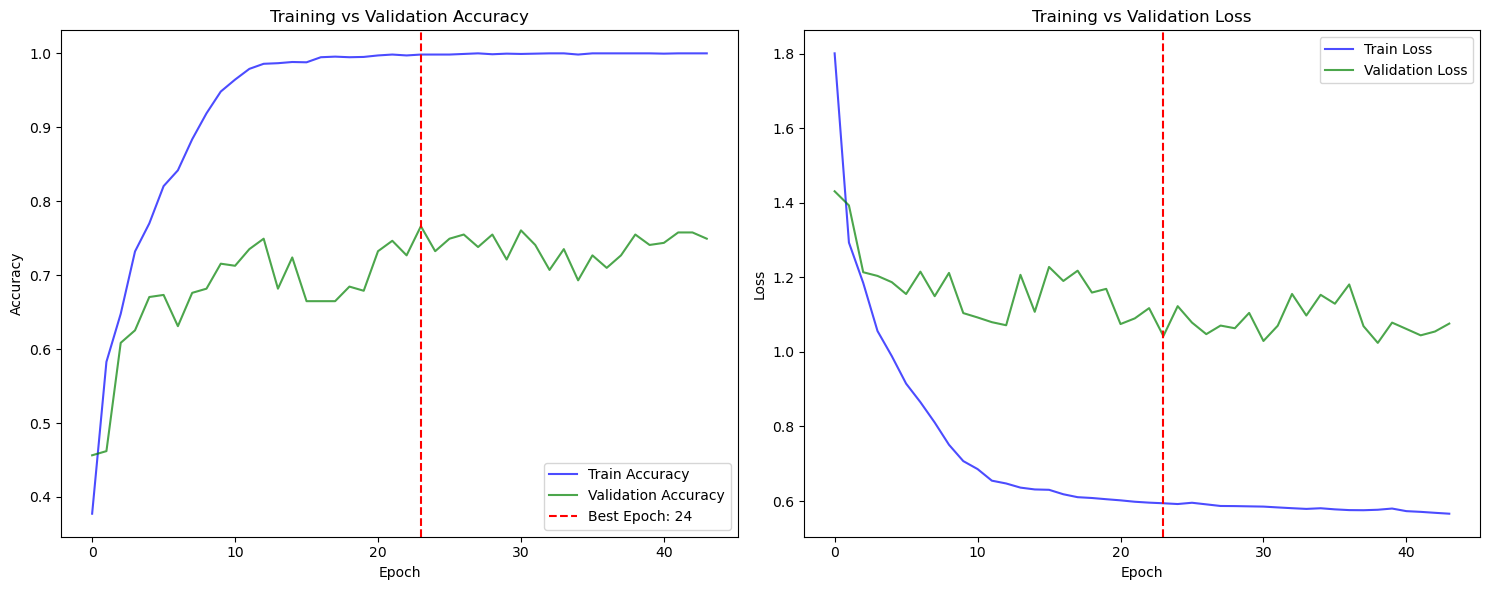

Training complete. Best Val Accuracy: 0.7662 at epoch 24
Classes present in test set: ['neutral', 'happy', 'sad', 'angry', 'surprise', 'disgust', 'fear']
              precision    recall  f1-score   support

     neutral       0.95      0.97      0.96       101
       happy       0.93      0.93      0.93       101
         sad       0.95      0.97      0.96       101
       angry       0.99      0.91      0.95       102
    surprise       1.00      0.98      0.99       101
     disgust       0.89      0.95      0.92       101
        fear       0.98      0.97      0.98       102

    accuracy                           0.95       709
   macro avg       0.96      0.95      0.96       709
weighted avg       0.96      0.95      0.96       709



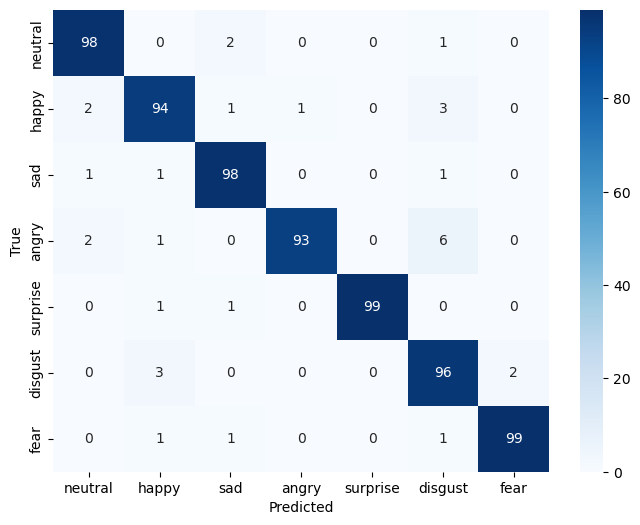

Weighted Accuracy: 0.9549

Run 3/10
Epoch 1/500, Train Loss: 1.6586, Val Loss: 1.4271, Train Accuracy: 0.4209, Val Accuracy: 0.4817, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.4817
Epoch 2/500, Train Loss: 1.2921, Val Loss: 1.3238, Train Accuracy: 0.5940, Val Accuracy: 0.5718, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.5718
Epoch 3/500, Train Loss: 1.1640, Val Loss: 1.3132, Train Accuracy: 0.6638, Val Accuracy: 0.5690, LR: 0.000500
  No improvement. Patience counter: 1/20
Epoch 4/500, Train Loss: 1.0548, Val Loss: 1.3369, Train Accuracy: 0.7328, Val Accuracy: 0.5746, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.5746
Epoch 5/500, Train Loss: 0.9655, Val Loss: 1.3688, Train Accuracy: 0.7700, Val Accuracy: 0.5549, LR: 0.000500
  No improvement. Patience counter: 1/20
Epoch 6/500, Train Loss: 0.9291, Val Loss: 1.1981, Train Accuracy: 0.8047, Val Accuracy: 0.6423, LR: 0.000500
  New best mode

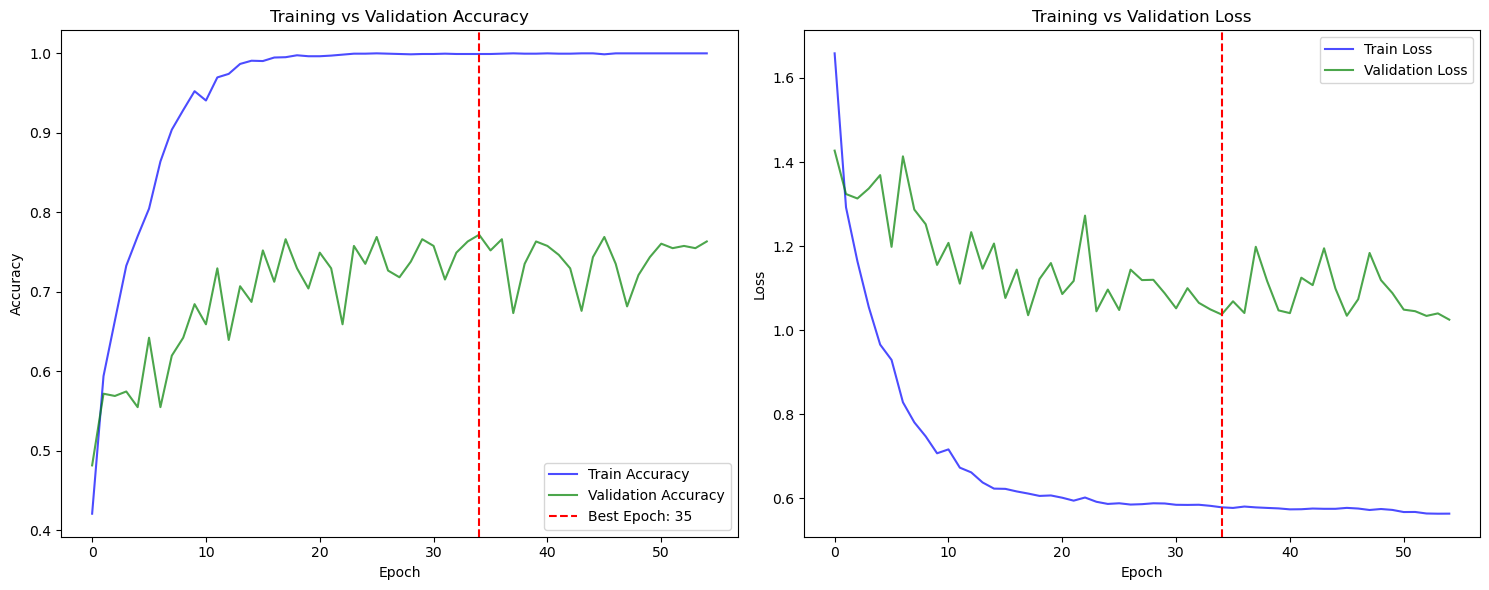

Training complete. Best Val Accuracy: 0.7718 at epoch 35
Classes present in test set: ['neutral', 'happy', 'sad', 'angry', 'surprise', 'disgust', 'fear']
              precision    recall  f1-score   support

     neutral       0.96      0.96      0.96       101
       happy       0.95      0.94      0.95       101
         sad       0.95      0.98      0.97       101
       angry       0.99      0.95      0.97       102
    surprise       1.00      0.98      0.99       101
     disgust       0.90      0.93      0.91       101
        fear       0.97      0.97      0.97       102

    accuracy                           0.96       709
   macro avg       0.96      0.96      0.96       709
weighted avg       0.96      0.96      0.96       709



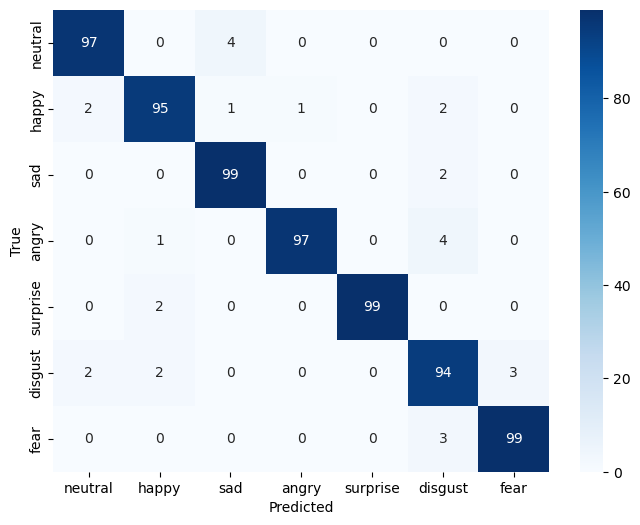

Weighted Accuracy: 0.9591

Run 4/10
Epoch 1/500, Train Loss: 1.6714, Val Loss: 1.4609, Train Accuracy: 0.4104, Val Accuracy: 0.4986, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.4986
Epoch 2/500, Train Loss: 1.2710, Val Loss: 1.3508, Train Accuracy: 0.6045, Val Accuracy: 0.5634, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.5634
Epoch 3/500, Train Loss: 1.1810, Val Loss: 1.5224, Train Accuracy: 0.6703, Val Accuracy: 0.4873, LR: 0.000500
  No improvement. Patience counter: 1/20
Epoch 4/500, Train Loss: 1.0676, Val Loss: 1.6417, Train Accuracy: 0.7337, Val Accuracy: 0.4704, LR: 0.000500
  No improvement. Patience counter: 2/20
Epoch 5/500, Train Loss: 0.9588, Val Loss: 1.2503, Train Accuracy: 0.7974, Val Accuracy: 0.6394, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.6394
Epoch 6/500, Train Loss: 0.8936, Val Loss: 1.4919, Train Accuracy: 0.8333, Val Accuracy: 0.5324, LR: 0.000500
  No improvemen

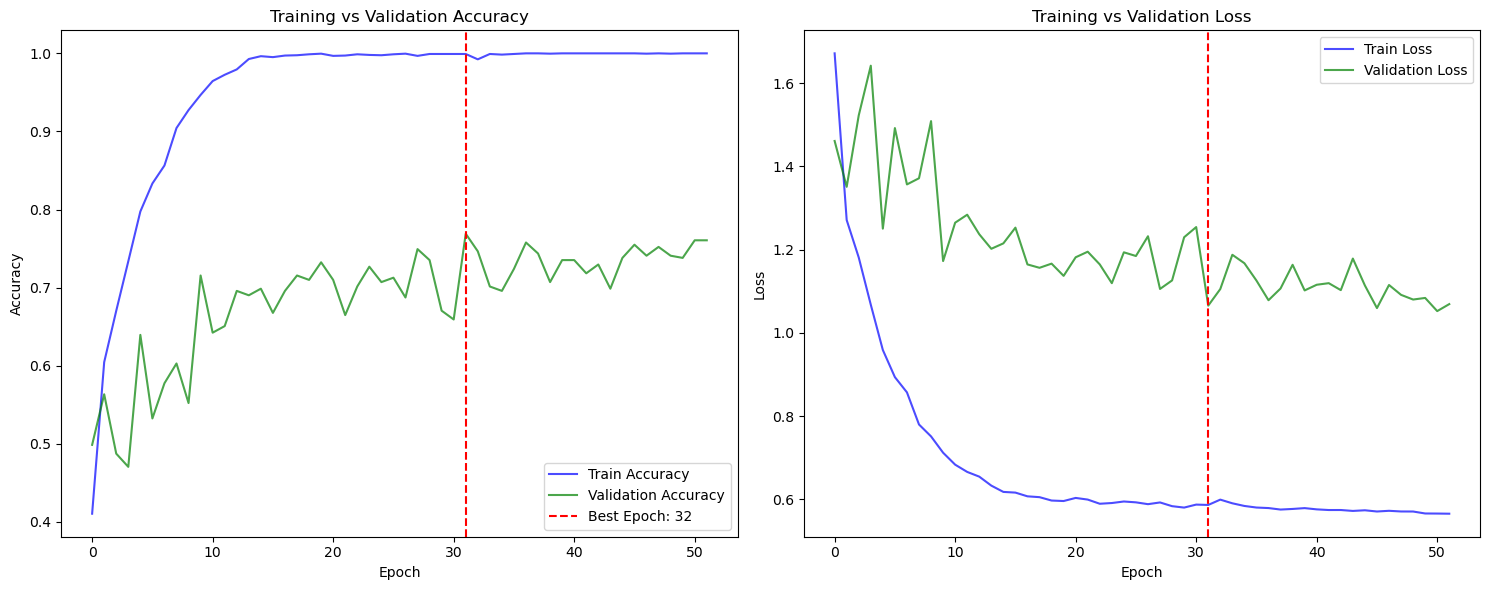

Training complete. Best Val Accuracy: 0.7690 at epoch 32
Classes present in test set: ['neutral', 'happy', 'sad', 'angry', 'surprise', 'disgust', 'fear']
              precision    recall  f1-score   support

     neutral       0.98      0.96      0.97       101
       happy       0.94      0.94      0.94       101
         sad       0.96      0.97      0.97       101
       angry       0.98      0.93      0.95       102
    surprise       0.98      0.97      0.98       101
     disgust       0.93      0.99      0.96       101
        fear       0.98      0.98      0.98       102

    accuracy                           0.96       709
   macro avg       0.96      0.96      0.96       709
weighted avg       0.96      0.96      0.96       709



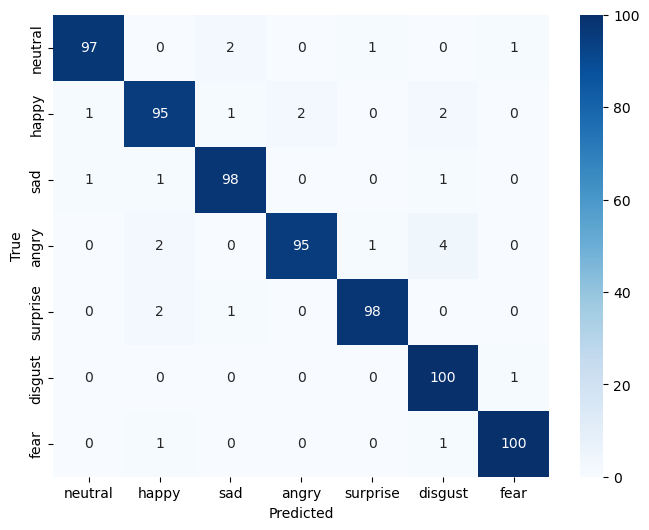

Weighted Accuracy: 0.9633

Run 5/10
Epoch 1/500, Train Loss: 1.7014, Val Loss: 1.4213, Train Accuracy: 0.4068, Val Accuracy: 0.5099, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.5099
Epoch 2/500, Train Loss: 1.3208, Val Loss: 1.3505, Train Accuracy: 0.5831, Val Accuracy: 0.5437, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.5437
Epoch 3/500, Train Loss: 1.1650, Val Loss: 1.2446, Train Accuracy: 0.6638, Val Accuracy: 0.6028, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.6028
Epoch 4/500, Train Loss: 1.0584, Val Loss: 1.5019, Train Accuracy: 0.7260, Val Accuracy: 0.4930, LR: 0.000500
  No improvement. Patience counter: 1/20
Epoch 5/500, Train Loss: 0.9610, Val Loss: 1.4523, Train Accuracy: 0.7885, Val Accuracy: 0.5437, LR: 0.000500
  No improvement. Patience counter: 2/20
Epoch 6/500, Train Loss: 0.8779, Val Loss: 1.2583, Train Accuracy: 0.8374, Val Accuracy: 0.6225, LR: 0.000500
  New best mode

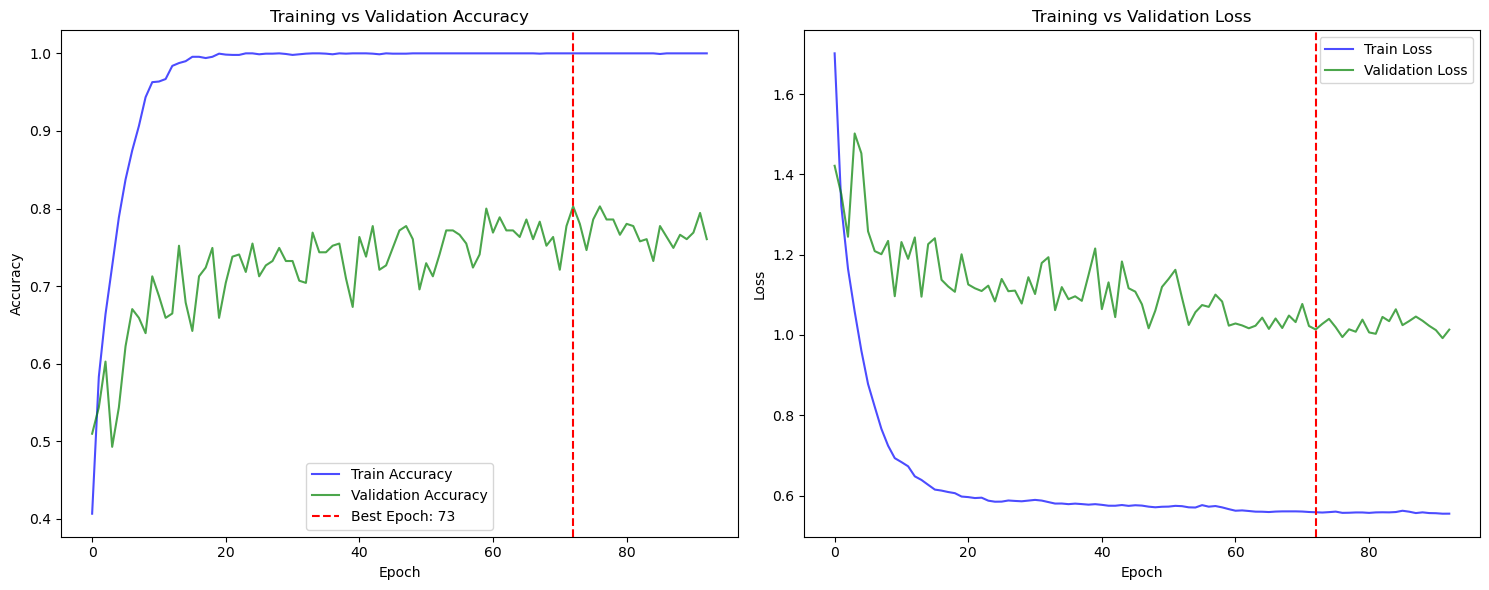

Training complete. Best Val Accuracy: 0.8028 at epoch 73
Classes present in test set: ['neutral', 'happy', 'sad', 'angry', 'surprise', 'disgust', 'fear']
              precision    recall  f1-score   support

     neutral       0.98      0.96      0.97       101
       happy       0.96      0.92      0.94       101
         sad       0.88      0.98      0.93       101
       angry       0.98      0.96      0.97       102
    surprise       0.99      0.98      0.99       101
     disgust       0.93      0.92      0.93       101
        fear       1.00      0.98      0.99       102

    accuracy                           0.96       709
   macro avg       0.96      0.96      0.96       709
weighted avg       0.96      0.96      0.96       709



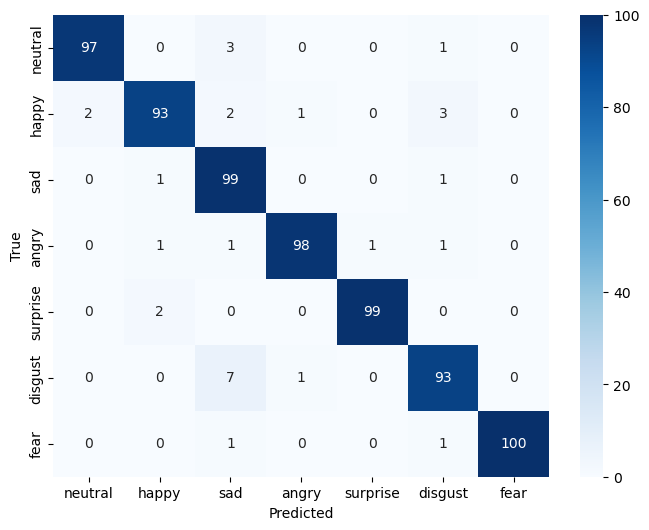

Weighted Accuracy: 0.9577

Run 6/10
Epoch 1/500, Train Loss: 1.7353, Val Loss: 1.4391, Train Accuracy: 0.4068, Val Accuracy: 0.4451, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.4451
Epoch 2/500, Train Loss: 1.3357, Val Loss: 1.4377, Train Accuracy: 0.5638, Val Accuracy: 0.4789, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.4789
Epoch 3/500, Train Loss: 1.1567, Val Loss: 1.2422, Train Accuracy: 0.6614, Val Accuracy: 0.5831, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.5831
Epoch 4/500, Train Loss: 1.0739, Val Loss: 1.3045, Train Accuracy: 0.7135, Val Accuracy: 0.5690, LR: 0.000500
  No improvement. Patience counter: 1/20
Epoch 5/500, Train Loss: 0.9975, Val Loss: 1.5812, Train Accuracy: 0.7667, Val Accuracy: 0.4873, LR: 0.000500
  No improvement. Patience counter: 2/20
Epoch 6/500, Train Loss: 0.9184, Val Loss: 1.1977, Train Accuracy: 0.8156, Val Accuracy: 0.6451, LR: 0.000500
  New best mode

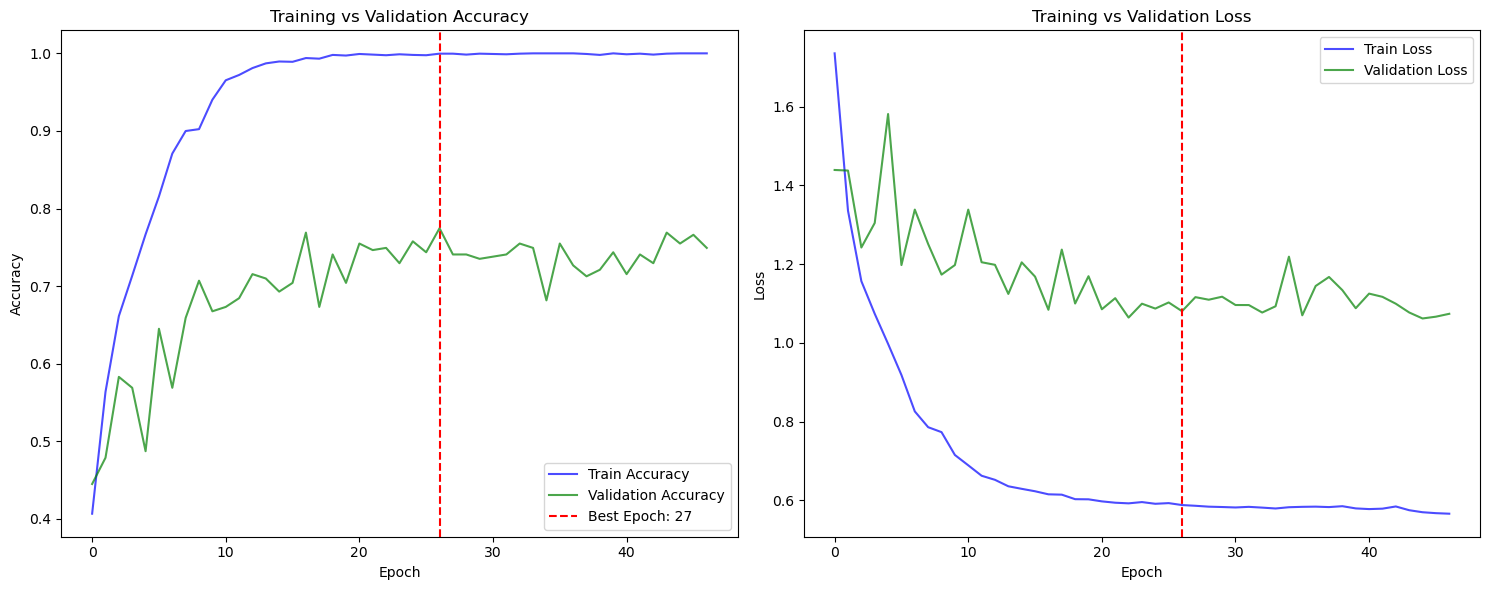

Training complete. Best Val Accuracy: 0.7746 at epoch 27
Classes present in test set: ['neutral', 'happy', 'sad', 'angry', 'surprise', 'disgust', 'fear']
              precision    recall  f1-score   support

     neutral       0.95      0.98      0.97       101
       happy       0.96      0.95      0.96       101
         sad       0.93      0.98      0.96       101
       angry       0.99      0.95      0.97       102
    surprise       1.00      0.97      0.98       101
     disgust       0.96      0.91      0.93       101
        fear       0.93      0.98      0.96       102

    accuracy                           0.96       709
   macro avg       0.96      0.96      0.96       709
weighted avg       0.96      0.96      0.96       709



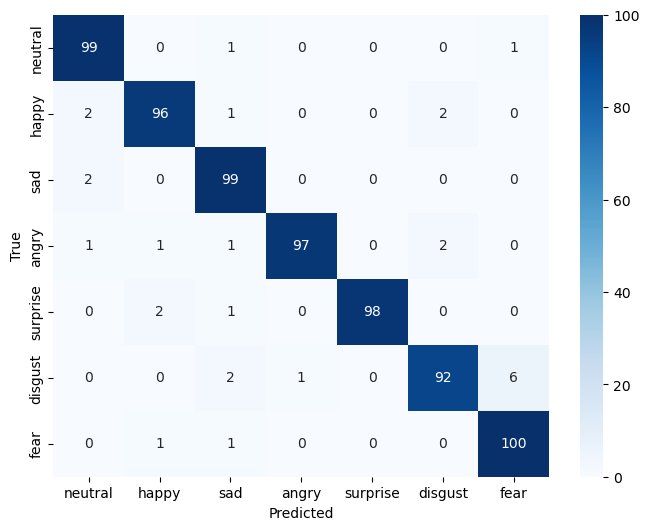

Weighted Accuracy: 0.9605

Run 7/10
Epoch 1/500, Train Loss: 1.7922, Val Loss: 1.5233, Train Accuracy: 0.3838, Val Accuracy: 0.4197, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.4197
Epoch 2/500, Train Loss: 1.3475, Val Loss: 1.4445, Train Accuracy: 0.5686, Val Accuracy: 0.5014, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.5014
Epoch 3/500, Train Loss: 1.2104, Val Loss: 1.3623, Train Accuracy: 0.6324, Val Accuracy: 0.5746, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.5746
Epoch 4/500, Train Loss: 1.0968, Val Loss: 1.2728, Train Accuracy: 0.7062, Val Accuracy: 0.5915, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.5915
Epoch 5/500, Train Loss: 0.9997, Val Loss: 1.2724, Train Accuracy: 0.7587, Val Accuracy: 0.6000, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.6000
Epoch 6/500, Train Loss: 0.9366, Val Loss: 1.2417, Train Accuracy: 0.

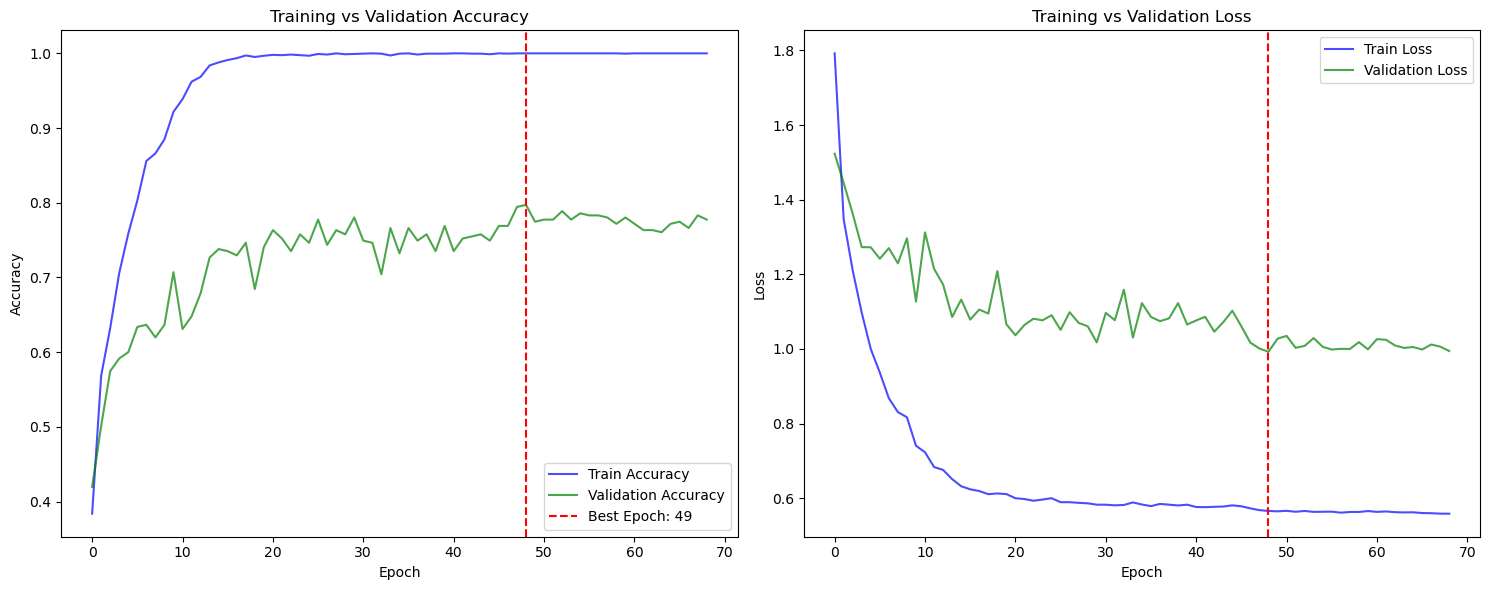

Training complete. Best Val Accuracy: 0.7972 at epoch 49
Classes present in test set: ['neutral', 'happy', 'sad', 'angry', 'surprise', 'disgust', 'fear']
              precision    recall  f1-score   support

     neutral       0.97      0.97      0.97       101
       happy       0.96      0.94      0.95       101
         sad       0.95      0.98      0.97       101
       angry       0.99      0.96      0.98       102
    surprise       1.00      0.98      0.99       101
     disgust       0.93      0.98      0.96       101
        fear       0.98      0.97      0.98       102

    accuracy                           0.97       709
   macro avg       0.97      0.97      0.97       709
weighted avg       0.97      0.97      0.97       709



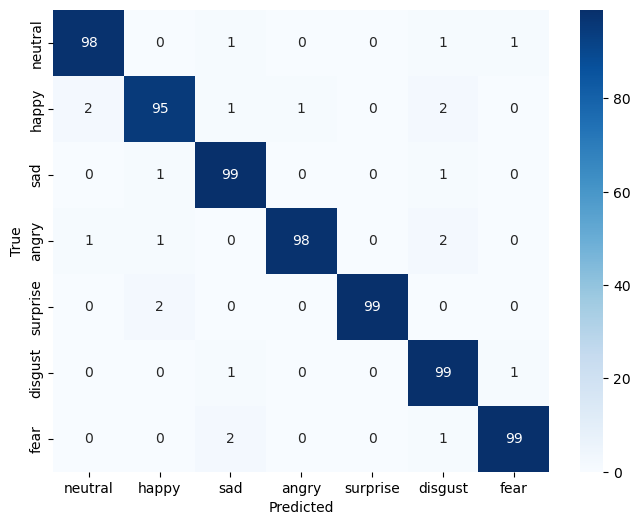

Weighted Accuracy: 0.9690

Run 8/10
Epoch 1/500, Train Loss: 1.7674, Val Loss: 1.5303, Train Accuracy: 0.4019, Val Accuracy: 0.4479, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.4479
Epoch 2/500, Train Loss: 1.3459, Val Loss: 1.3953, Train Accuracy: 0.5504, Val Accuracy: 0.5296, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.5296
Epoch 3/500, Train Loss: 1.2149, Val Loss: 1.2965, Train Accuracy: 0.6408, Val Accuracy: 0.5718, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.5718
Epoch 4/500, Train Loss: 1.1286, Val Loss: 1.2581, Train Accuracy: 0.6877, Val Accuracy: 0.5775, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.5775
Epoch 5/500, Train Loss: 1.0279, Val Loss: 1.2465, Train Accuracy: 0.7530, Val Accuracy: 0.6028, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.6028
Epoch 6/500, Train Loss: 0.9590, Val Loss: 1.3237, Train Accuracy: 0.

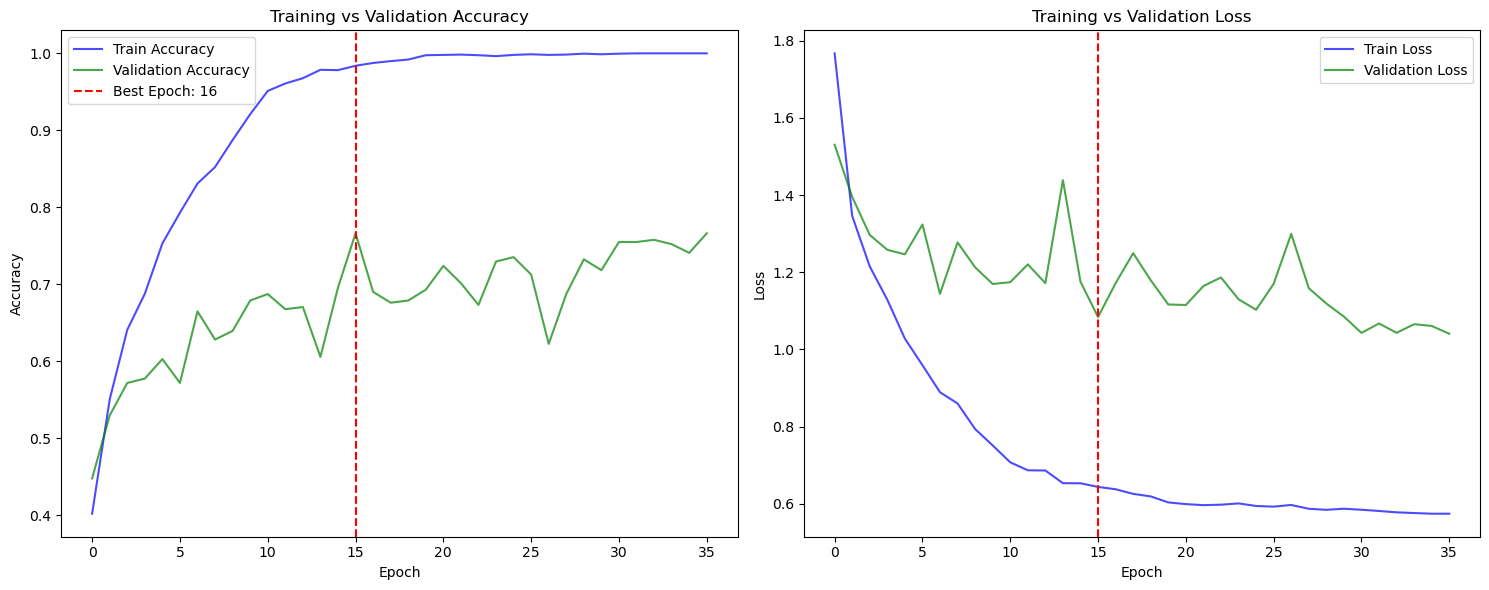

Training complete. Best Val Accuracy: 0.7662 at epoch 16
Classes present in test set: ['neutral', 'happy', 'sad', 'angry', 'surprise', 'disgust', 'fear']
              precision    recall  f1-score   support

     neutral       0.96      0.95      0.96       101
       happy       0.95      0.94      0.95       101
         sad       0.93      0.98      0.96       101
       angry       0.99      0.94      0.96       102
    surprise       1.00      0.98      0.99       101
     disgust       0.92      0.96      0.94       101
        fear       0.98      0.98      0.98       102

    accuracy                           0.96       709
   macro avg       0.96      0.96      0.96       709
weighted avg       0.96      0.96      0.96       709



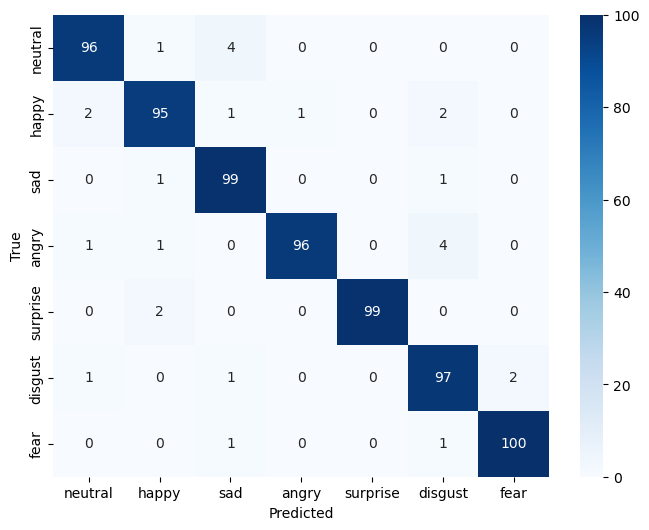

Weighted Accuracy: 0.9619

Run 9/10
Epoch 1/500, Train Loss: 1.7099, Val Loss: 1.4578, Train Accuracy: 0.4124, Val Accuracy: 0.4620, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.4620
Epoch 2/500, Train Loss: 1.2821, Val Loss: 1.3340, Train Accuracy: 0.5993, Val Accuracy: 0.6000, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.6000
Epoch 3/500, Train Loss: 1.1472, Val Loss: 1.3082, Train Accuracy: 0.6792, Val Accuracy: 0.5549, LR: 0.000500
  No improvement. Patience counter: 1/20
Epoch 4/500, Train Loss: 1.0403, Val Loss: 1.3450, Train Accuracy: 0.7433, Val Accuracy: 0.5493, LR: 0.000500
  No improvement. Patience counter: 2/20
Epoch 5/500, Train Loss: 0.9670, Val Loss: 1.2627, Train Accuracy: 0.7930, Val Accuracy: 0.5944, LR: 0.000500
  No improvement. Patience counter: 3/20
Epoch 6/500, Train Loss: 0.9198, Val Loss: 1.3131, Train Accuracy: 0.8273, Val Accuracy: 0.6169, LR: 0.000500
  New best model saved to CSE499_Model.pth 

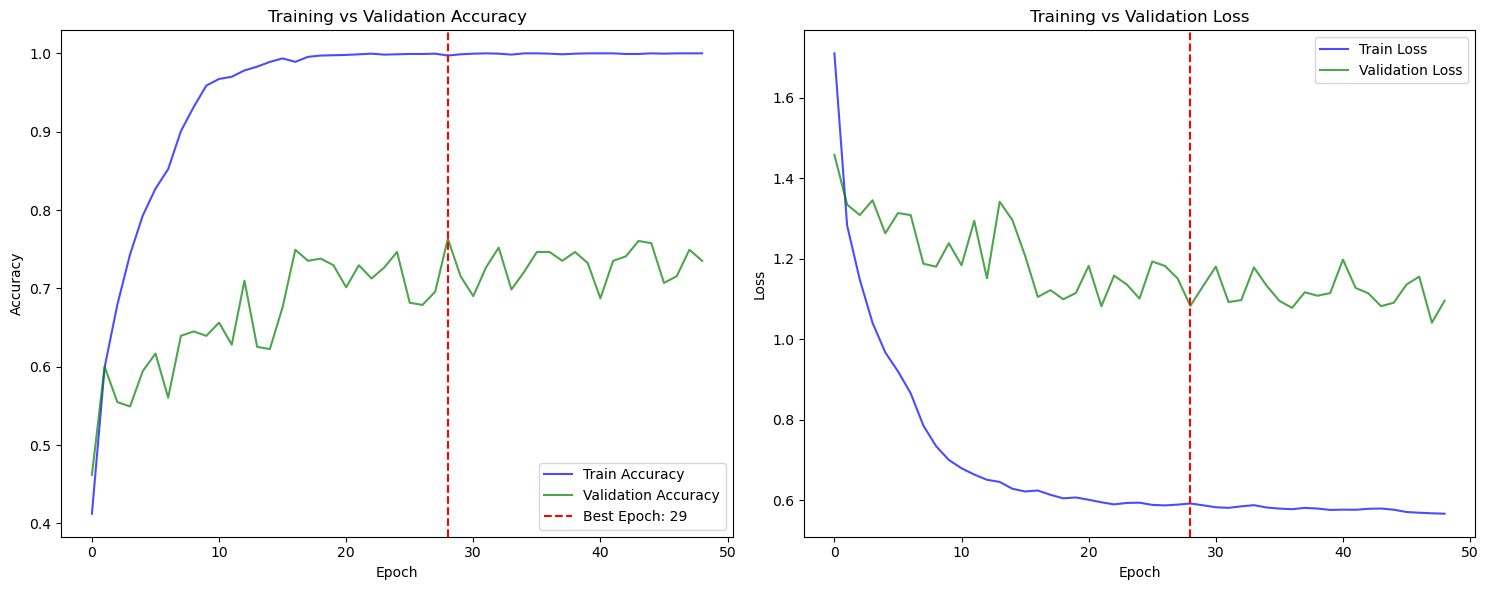

Training complete. Best Val Accuracy: 0.7634 at epoch 29
Classes present in test set: ['neutral', 'happy', 'sad', 'angry', 'surprise', 'disgust', 'fear']
              precision    recall  f1-score   support

     neutral       0.96      0.96      0.96       101
       happy       0.97      0.93      0.95       101
         sad       0.97      0.99      0.98       101
       angry       0.98      0.92      0.95       102
    surprise       0.99      0.98      0.99       101
     disgust       0.90      0.99      0.94       101
        fear       0.99      0.98      0.99       102

    accuracy                           0.96       709
   macro avg       0.97      0.96      0.96       709
weighted avg       0.97      0.96      0.96       709



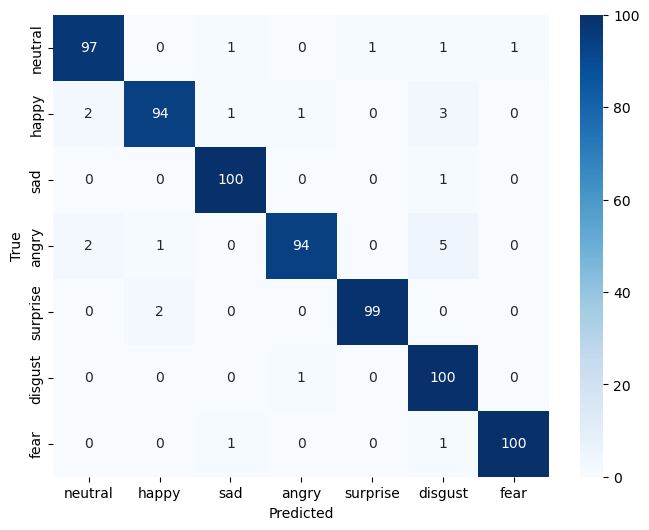

Weighted Accuracy: 0.9647

Run 10/10
Epoch 1/500, Train Loss: 1.6922, Val Loss: 1.4600, Train Accuracy: 0.4068, Val Accuracy: 0.4423, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.4423
Epoch 2/500, Train Loss: 1.3197, Val Loss: 1.4322, Train Accuracy: 0.5771, Val Accuracy: 0.5268, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.5268
Epoch 3/500, Train Loss: 1.1708, Val Loss: 1.2676, Train Accuracy: 0.6533, Val Accuracy: 0.5634, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.5634
Epoch 4/500, Train Loss: 1.0757, Val Loss: 1.4077, Train Accuracy: 0.7163, Val Accuracy: 0.5042, LR: 0.000500
  No improvement. Patience counter: 1/20
Epoch 5/500, Train Loss: 0.9639, Val Loss: 1.2722, Train Accuracy: 0.7934, Val Accuracy: 0.5915, LR: 0.000500
  New best model saved to CSE499_Model.pth with Val Accuracy: 0.5915
Epoch 6/500, Train Loss: 0.9023, Val Loss: 1.3602, Train Accuracy: 0.8224, Val Accuracy: 0.5803,

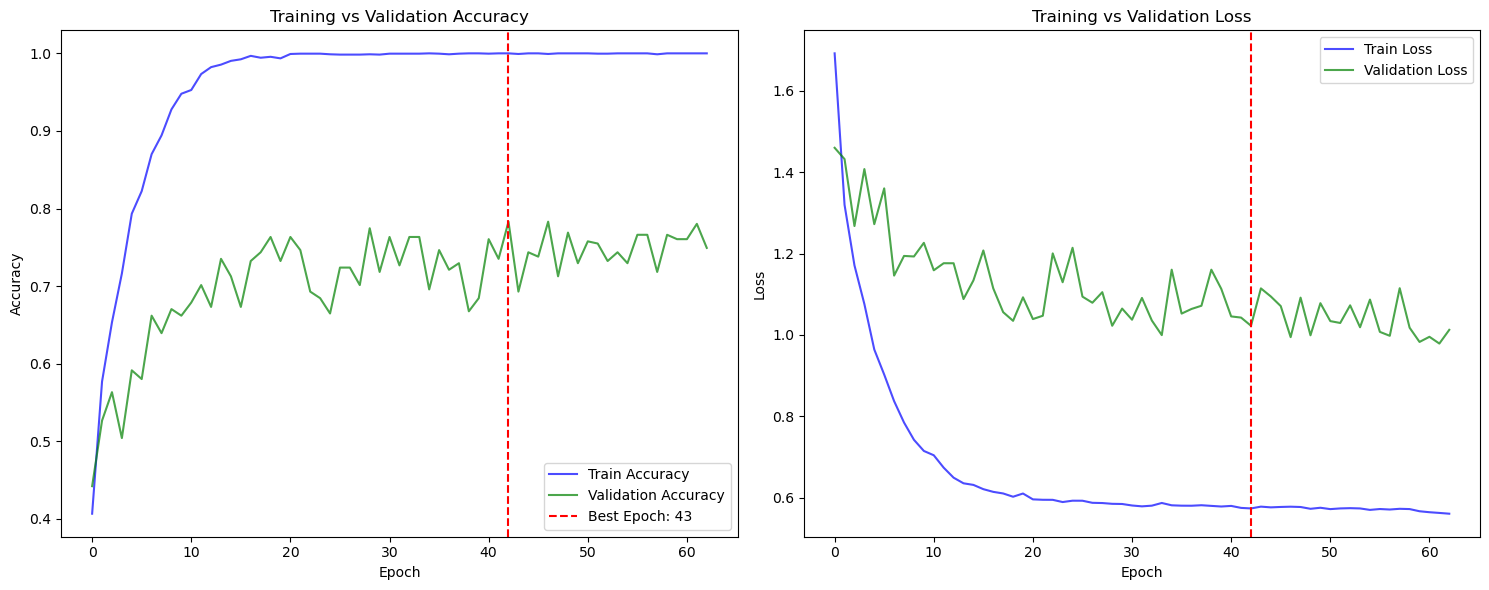

Training complete. Best Val Accuracy: 0.7831 at epoch 43
Classes present in test set: ['neutral', 'happy', 'sad', 'angry', 'surprise', 'disgust', 'fear']
              precision    recall  f1-score   support

     neutral       0.95      0.96      0.96       101
       happy       0.96      0.94      0.95       101
         sad       0.95      0.97      0.96       101
       angry       1.00      0.96      0.98       102
    surprise       1.00      0.98      0.99       101
     disgust       0.91      0.99      0.95       101
        fear       1.00      0.96      0.98       102

    accuracy                           0.97       709
   macro avg       0.97      0.97      0.97       709
weighted avg       0.97      0.97      0.97       709



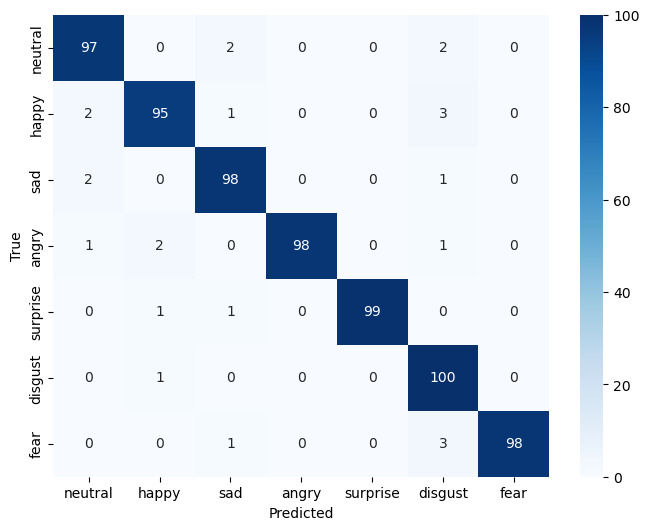

Weighted Accuracy: 0.9661

Results over 10 runs:
Mean Weighted Accuracy: 0.9622 ± 0.0040


In [16]:
#Multiple runs (10 times)
print("\nStarting 10-run evaluation...")
weighted_accs = []
num_runs = 10
for run in range(num_runs):
    print(f"\nRun {run + 1}/{num_runs}")
    torch.cuda.empty_cache()
    model = CNNTransformerHybrid(num_classes=7).to(device)  # Re-initialize model for random weights
    model = train_model(model, train_loader, val_loader, num_epochs=500, patience=20)
    weighted_acc = evaluate_model(model, test_loader, label_map)
    weighted_accs.append(weighted_acc)

# Compute mean and standard deviation
mean_acc = np.mean(weighted_accs)
std_acc = np.std(weighted_accs)
print(f"\nResults over {num_runs} runs:")
print(f"Mean Weighted Accuracy: {mean_acc:.4f} ± {std_acc:.4f}")